# Entendiendo la Paralelización en Apache Spark: Un Vistazo a Bajo Nivel con RDDs

**Objetivo del Notebook:** Este notebook tiene como finalidad desmitificar cómo Apache Spark logra el procesamiento paralelo de datos. No nos quedaremos en la superficie; exploraremos la arquitectura y el flujo de ejecución a bajo nivel, utilizando los RDDs (Resilient Distributed Datasets) como base para entender los conceptos de particiones, tareas, etapas y trabajos.

## 1. La Arquitectura Física: Driver y Executors

Para entender la paralelización, primero debemos conocer a los actores principales en cualquier aplicación de Spark.

### El Driver (El Cerebro)
Es el proceso donde se ejecuta nuestro programa principal (este notebook). Su función es mantener la información de la aplicación, pero su tarea más crítica es **analizar, planificar y distribuir el trabajo** entre los procesos trabajadores.

### Los Executors (Los Trabajadores)
Son procesos que se ejecutan en los nodos de trabajo del clúster. En el entorno de Colab, son hilos de ejecución en la misma máquina. Su única misión es **ejecutar el código y procesar los datos** que el Driver les asigna. Cada Executor tiene su propia porción de memoria y núcleos de CPU.



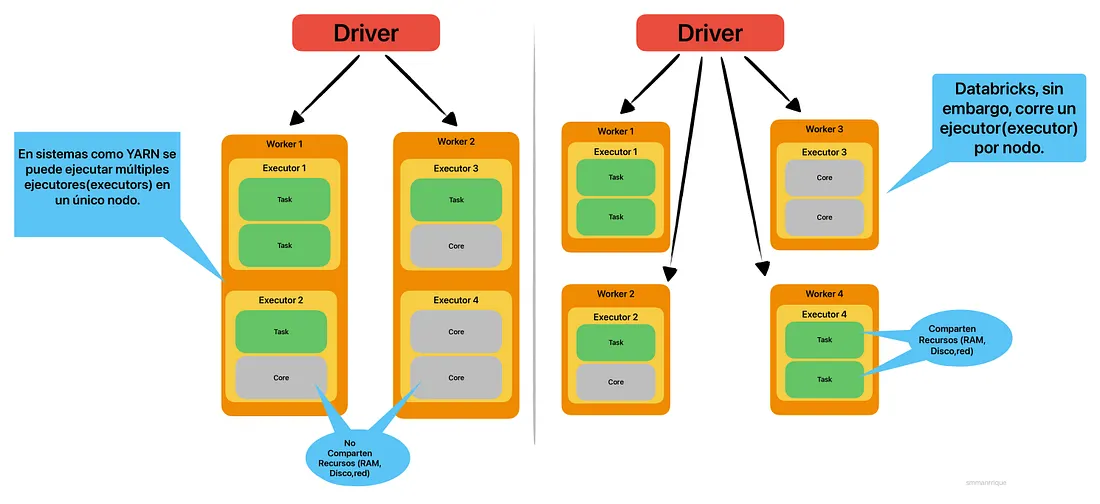

## 2. La Unidad Fundamental de Paralelismo: Particiones

Un RDD es una **abstracción lógica** de un conjunto de datos distribuido. Sin embargo, físicamente, los datos se dividen en fragmentos más pequeños llamados **particiones**.

* **¿Qué es una Partición?** Es un bloque de datos que reside físicamente en la memoria de un Executor. Es la unidad atómica de procesamiento en Spark.
* **La Regla de Oro del Paralelismo:** El número de tareas que se ejecutan en paralelo para una etapa es igual al número de particiones del RDD. Si un RDD tiene 8 particiones, Spark lanzará 8 tareas para procesarlo en paralelo.

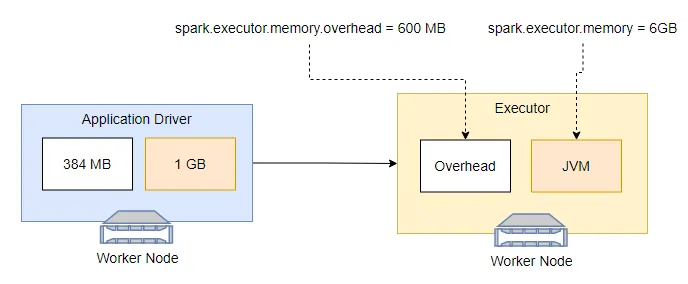



In [1]:
# =================================================================
# 3. Configuración del Entorno Spark en Colab
# =================================================================
# El comando `-q` (quiet) reduce la cantidad de texto durante la instalación.
!pip install pyspark -q

from pyspark import SparkContext, SparkConf

# Configuración del SparkContext. Esta parte es fundamental para entender el paralelismo local.
# - setMaster("local[*]"):
#   - "local": Indica a Spark que se ejecute en una sola máquina (el entorno de Colab).
#   - "[*]": Es la instrucción clave. Le dice a Spark que cree tantos hilos de trabajador
#     como núcleos de CPU lógicos estén disponibles en la máquina. Esto nos permite
#     simular y observar el paralelismo real sin necesidad de un clúster físico.
conf = SparkConf().setAppName("ClaseBajoNivel").setMaster("local[*]")
sc = SparkContext(conf=conf)

print(f"SparkContext iniciado correctamente.")
print(f"Versión de Spark: {sc.version}")
print(f"Modo de ejecución (Master): {sc.master}")

SparkContext iniciado correctamente.
Versión de Spark: 3.5.1
Modo de ejecución (Master): local[*]


In [2]:
# =================================================================
# 4. Creación de un RDD y Visualización de las Particiones
# =================================================================
# Creamos una lista de datos simple en el nodo DRIVER.
data = range(1, 101) # Una lista con números del 1 al 100.

# Usamos `sc.parallelize()` para distribuir esta colección a través de los EXECUTORS.
# Especificamos explícitamente que queremos dividir los datos en 4 PARTICIONES.
rdd = sc.parallelize(data, 4)

# Verifiquemos el grado de paralelismo de nuestro RDD.
print(f"El RDD ha sido creado con {rdd.getNumPartitions()} particiones.")

# TÉCNICA DE BAJO NIVEL PARA VISUALIZACIÓN:
# La transformación `glom()` es una herramienta de depuración muy útil.
# Agrupa todos los elementos que pertenecen a la misma partición en una lista.
# Al aplicar `collect()`, traemos una lista de listas al Driver, donde cada
# lista interna representa el contenido exacto de una partición.
contenido_particiones = rdd.glom().collect()

print("\nInspeccionando el contenido real de cada partición:")
for i, particion in enumerate(contenido_particiones):
    # Mostramos solo los primeros 5 elementos y el tamaño para claridad.
    print(f"  -> Partición {i} (tamaño: {len(particion)}): {particion[:5]}...")

El RDD ha sido creado con 4 particiones.

Inspeccionando el contenido real de cada partición:
  -> Partición 0 (tamaño: 25): [1, 2, 3, 4, 5]...
  -> Partición 1 (tamaño: 25): [26, 27, 28, 29, 30]...
  -> Partición 2 (tamaño: 25): [51, 52, 53, 54, 55]...
  -> Partición 3 (tamaño: 25): [76, 77, 78, 79, 80]...


## 5. El Flujo de Ejecución: Jobs, Stages y Tasks

Cuando llamamos a una **acción** (ej. `collect()`, `count()`), Spark no ejecuta el código de forma ingenua. Sigue un plan de batalla sofisticado:

1.  **Job:** Una acción desencadena un **Job**. Cada Job corresponde a una "misión" completa que debe ser ejecutada.
2.  **DAG (Grafo Acíclico Dirigido):** El Driver toma la secuencia de transformaciones del RDD y la convierte en un plan de ejecución llamado DAG. Este plan representa las dependencias entre las operaciones.
3.  **Stages (Etapas):** El Driver analiza el DAG y lo divide en **Stages**. Una etapa es un conjunto de tareas que se pueden ejecutar juntas sin necesidad de mover datos masivamente entre todos los executors. El límite entre etapas lo marca una operación de **Shuffle** (una reorganización costosa de datos, como en un `groupByKey`).
4.  **Tasks (Tareas):** Finalmente, cada etapa se divide en **Tasks**. La regla es simple: se lanza **una tarea por cada partición** de la etapa. Esta es la unidad de trabajo más pequeña, ejecutada por un Executor.

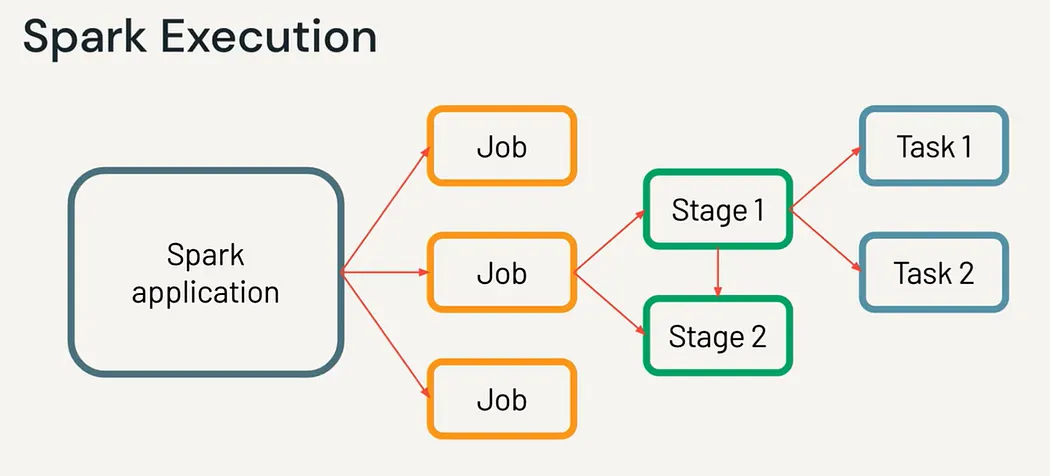

In [5]:
# =================================================================
# 6. Demostración: Transformaciones (Lazy) y Acciones (Eager)
# =================================================================
# A continuación, aplicaremos dos transformaciones.
# Estas operaciones son "perezosas" (lazy), lo que significa que Spark
# solo está construyendo el plan (DAG), no ejecutando nada todavía.

# Transformación 1 (Narrow): Filtrar números.
# Esta operación no requiere datos de otras particiones.
rdd_filtrado = rdd.filter(lambda x: x % 10 == 0)

# Transformación 2 (Narrow): Mapear los números filtrados a un texto.
rdd_mapeado = rdd_filtrado.map(lambda x: f"Valor encontrado: {x}")

# Podemos inspeccionar el linaje o plan de ejecución del RDD final usando `toDebugString()`.
# Esto nos muestra el DAG que Spark ha construido internamente.
print("--- Plan de Ejecución (DAG) Construido por Spark ---")
# El método retorna bytes, por lo que se debe decodificar a string.
print(rdd_mapeado.toDebugString().decode())
print("----------------------------------------------------")

# Ahora, llamamos a una ACCIÓN.
# La acción `collect()` le ordena al Driver que ejecute el plan (el DAG).
# Esto crea un JOB, que se divide en STAGES y luego en TASKS que se envían a los EXECUTORS.
print("\n¡Llamando a la ACCIÓN `collect()`! La computación se ejecuta AHORA.")
resultados_finales = rdd_mapeado.collect()

print("\nResultados obtenidos después de la ejecución paralela:")
print(resultados_finales)

# Es una buena práctica detener el SparkContext para liberar los recursos.
sc.stop()

print("\nSparkContext detenido.")

--- Plan de Ejecución (DAG) Construido por Spark ---
(4) PythonRDD[2] at RDD at PythonRDD.scala:53 []
 |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289 []
----------------------------------------------------

¡Llamando a la ACCIÓN `collect()`! La computación se ejecuta AHORA.

Resultados obtenidos después de la ejecución paralela:
['Valor encontrado: 10', 'Valor encontrado: 20', 'Valor encontrado: 30', 'Valor encontrado: 40', 'Valor encontrado: 50', 'Valor encontrado: 60', 'Valor encontrado: 70', 'Valor encontrado: 80', 'Valor encontrado: 90', 'Valor encontrado: 100']

SparkContext detenido.


# 7. Aplicación con un Conjunto de Datos Real: El Titanic

Ahora que entendemos los mecanismos internos con datos simples, apliquemos los mismos conceptos a un conjunto de datos real. Usaremos un archivo CSV con la lista de pasajeros del Titanic.

El objetivo es ver que los principios de paralelización no cambian:

1.  Leeremos una fuente de datos externa, que Spark dividirá automáticamente en **particiones**.
2.  Aplicaremos **transformaciones** perezosas para construir un DAG.
3.  Llamaremos a una **acción** para ejecutar el **Job** en paralelo.

In [6]:
# =================================================================
# Paso 1: Descargar el conjunto de datos en el entorno de Colab
# =================================================================
# Usamos el comando `wget` para descargar el archivo CSV desde una URL pública.
# El archivo se guardará localmente en nuestro entorno de Colab.
!wget -q https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv -O titanic.csv

print("Archivo titanic.csv descargado.")

Archivo titanic.csv descargado.


In [7]:
# =================================================================
# Paso 2: Cargar el archivo como un RDD
# =================================================================
from pyspark import SparkContext, SparkConf

# Configuración del SparkContext. Es necesario reiniciarlo
# ya que fue detenido en la celda anterior.
conf = SparkConf().setAppName("AnalisisTitanic").setMaster("local[*]")
sc = SparkContext(conf=conf)

# En lugar de `sc.parallelize`, usamos `sc.textFile` para leer una fuente de datos.
# Spark lee el archivo y lo distribuye en particiones automáticamente,
# permitiendo el procesamiento paralelo desde el inicio.
rdd_titanic_raw = sc.textFile("titanic.csv")

# Veamos cuántas particiones creó Spark por defecto para este archivo.
print(f"El RDD del Titanic fue creado con {rdd_titanic_raw.getNumPartitions()} particiones.")

# Inspeccionemos las primeras 5 líneas del archivo.
# Vemos que es un RDD de strings, donde cada string es una línea del CSV.
print("\nPrimeras 5 líneas del RDD en crudo:")
for line in rdd_titanic_raw.take(5):
    print(line)

El RDD del Titanic fue creado con 2 particiones.

Primeras 5 líneas del RDD en crudo:
PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S


### Nuestro Mini-Análisis

Vamos a realizar una tarea simple: **Obtener los nombres de todos los pasajeros de primera clase ('Pclass' = 1) que sobrevivieron ('Survived' = 1).**

Para lograrlo, necesitamos realizar varias transformaciones:
1.  **Extraer el encabezado:** La primera línea del archivo no son datos y debe ser eliminada.
2.  **Parsear el CSV:** Cada línea es un string. Necesitamos dividirla por las comas para acceder a las columnas individuales.
3.  **Filtrar por sobrevivientes:** Mantener solo las filas donde la columna 'Survived' sea '1'.
4.  **Filtrar por clase:** De los sobrevivientes, mantener solo aquellos donde 'Pclass' sea '1'.
5.  **Mapear al nombre:** Extraer únicamente la columna del nombre del pasajero.

In [8]:
# =================================================================
# Paso 3: Aplicar Transformaciones (Lazy) y Ejecutar la Acción (Eager)
# =================================================================

# Extraemos la primera línea, que es el encabezado del CSV.
header = rdd_titanic_raw.first()

# Transformación: Filtramos el RDD para quitar la línea del encabezado.
rdd_no_header = rdd_titanic_raw.filter(lambda line: line != header)

# Transformación: Parseamos cada línea del CSV.
# `map` convierte cada string en una lista de campos al dividirla por la coma.
rdd_parsed = rdd_no_header.map(lambda line: line.split(","))

# Transformación: Filtramos para quedarnos solo con los pasajeros que sobrevivieron.
# La columna 'Survived' es la segunda (índice 1).
rdd_survivors = rdd_parsed.filter(lambda fields: fields[1] == "1")

# Transformación: De los sobrevivientes, filtramos por la primera clase.
# La columna 'Pclass' es la tercera (índice 2).
rdd_first_class = rdd_survivors.filter(lambda fields: fields[2] == "1")

# Transformación: Extraemos el nombre del pasajero.
# La columna 'Name' es la cuarta (índice 3).
rdd_names = rdd_first_class.map(lambda fields: fields[3])


# ----- NADA SE HA EJECUTADO HASTA AHORA -----
# Solo hemos construido un DAG complejo.

# ACCIÓN: `collect()` desencadena el Job completo.
# Spark ejecutará todas las transformaciones en paralelo a través de las particiones.
print("Ejecutando el Job para encontrar a los sobrevivientes de primera clase...")
nombres_sobrevivientes_primera_clase = rdd_names.collect()

print(f"\nSe encontraron {len(nombres_sobrevivientes_primera_clase)} sobrevivientes de primera clase.")
print("Algunos de sus nombres son:")
for name in nombres_sobrevivientes_primera_clase[:10]:
    print(f"- {name}")

# No olvides detener el SparkContext si es la última celda de tu notebook
# sc.stop()

Ejecutando el Job para encontrar a los sobrevivientes de primera clase...

Se encontraron 136 sobrevivientes de primera clase.
Algunos de sus nombres son:
- "Cumings
- "Futrelle
- "Bonnell
- "Sloper
- "Spencer
- "Harper
- "Woolner
- "Icard
- "Fortune
- "Greenfield
